In [1]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import random
import gym
import time
from collections import deque

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

70.5483090877533 seconds
Success rate: 0.0321


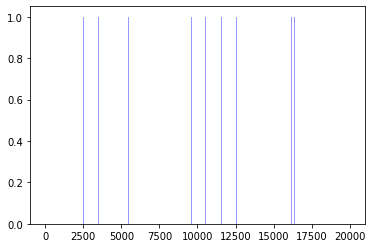

In [2]:
# target 임베딩
def one_hot(x):
    return np.identity(16)[x:x + 1].astype(np.float32)


env = gym.make('FrozenLake-v0')

# Set Q-learning parameters
num_episodes = 20000
learning_rate = 0.1
dis = .99
h_size = 10

# Input and output size based on the Env
input_size = env.observation_space.n
output_size = env.action_space.n

# weight 1  (16, 10)
W1 = tf.Variable(tf.random.uniform([input_size, h_size], 0, 0.01), dtype=tf.float32)

# weight 2  (10, 4)
W2 = tf.Variable(tf.random.uniform([h_size, output_size], 0, 0.01), dtype=tf.float32)

# optimizer
optimizer = tf.optimizers.SGD(learning_rate=learning_rate)
start_time = time.time()
# rewards per episode
rList = []
buffer = deque(maxlen=2000)

for i in range(num_episodes):
    # Reset environment and get first new observation
    state = env.reset()
    rAll = 0
    done = False
    save_weight = []

    e = 1. / ((i / 50) + 10)
    # The Q-Table learning algorithm
    while not done:
        # Choose an action by greedly (with a chance of random action) from the Q-network
        q_value = tf.matmul(one_hot(state), W1)
        activation = tf.nn.relu(q_value)
        q_value = tf.matmul(activation, W2)
        q_value = tf.nn.relu(q_value)
        q_value = np.array(q_value.numpy())

        save_weight.append(W2)

        if np.random.rand(1) < e:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_value)

        # Get new state and reward from environment
        state_next, reward, done, _ = env.step(action)
        buffer.append((state, action, reward, state_next, done))
        state = state_next

        if len(buffer) > 2000:
            pass
        if num_episodes % 10 == 1:
            for _ in range(50):
                sample = random.sample(buffer, 10)

                # sample의 개수 많큼 for문을 돌립니다
                for state, action, reward, state_next, done in sample:
                    if done:
                        q_value[0, action] = reward
                    else:
                        q_score_next = tf.matmul(one_hot(state_next), W1)
                        activation = tf.nn.relu(q_score_next)
                        q_score_next = tf.matmul(activation, W2)
                        q_score_next = tf.nn.relu(q_score_next)
                        q_score_next = np.array(q_score_next.numpy())

                        q_value[0, action] = reward + dis * np.max(q_score_next)

                # --------------------------------------------------------------------
               
                Qpred = tf.matmul(one_hot(state), W1)
                activation = tf.nn.relu(Qpred)
                loss = lambda: tf.reduce_sum(input_tensor=tf.square(q_value - tf.nn.relu(tf.matmul(Qpred, W2))))
                # optimizer, loss가 작아지는 방향으로 W 업데이트
                optimizer.minimize(loss, var_list=W2)


        rAll += reward
    # if i % 100 == 0:
    #     print(f'진행률: {round(i / num_episodes, 2) * 100}%')
    rList.append(rAll)

print(f'{(time.time() - start_time)} seconds')
print("Success rate: " + str(sum(rList) / num_episodes))
plt.bar(range(len(rList)), rList, color='b', alpha=0.4)
plt.show()
